# Model Performance Evaluation
Work for Masters Thesis

Stanley Fujimoto

In [1]:
import pickle
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier

from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
import math
import numpy as np

%matplotlib inline

/Users/masaki/software/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
available_features_str = "aliscore,length,num_seqs,num_gaps,num_amino_acids,range,amino_acid_charged,amino_acid_uncharged,amino_acid_special,amino_acid_hydrophobic"
available_features = available_features_str.split( ',' )

## Metaclassifier code

In [3]:
# code for meta classifier
available_models = "svm,neural_network,random_forest,naive_bayes,logistic_regression"

class Metaclassifier:
    '''
    a meta-classifier that uses several other base classifiers to produce its own classifications
    '''

    def __init__( self, model_names = available_models.split( ',' ) ):
        '''
        model_names = a python list of model names, the model names should correspond to the used models
        '''
        self.model_names = model_names
        for x in model_names:
            model_class = model_to_class[ x ]
            self.models = [ model_class( **( model_params[ model_class ] ) ) for x in model_names ]
        self.skip_models = [ 0 ] * len( self.models )
        self.models.append( MLPClassifier() )

    def generate_base_classifier_predictions( self, x, sx ):
        predictions = []
        # create predictions for all classifier except for the last one, the meta-classifier
        for idx, model in enumerate( self.models[ : -1 ] ):
            # if the model was untrainable during the bootstrapping process, we mark everything
            # as a homology cluster
            if self.skip_models[ idx ] == 1:
                predictions.append( np.array( [ 'H' ] * len( x ) ) )
            else:
                if isinstance( model, MultinomialNB ):
                    predictions.append( model.predict( x ) )
                else:
                    predictions.append( model.predict( sx ) )

        predictions = pd.DataFrame( predictions ).replace( { 'H' : 1, "NH" : 0 } ).transpose()
        predictions.columns = self.model_names
        return predictions

    def train_base_classifiers( self, x, sx, y ):
        for idx, model in enumerate( self.models[ : -1 ] ):
            try:
                if isinstance( model, MultinomialNB ):
                    # don't scale for NB
                    model.fit( x, y )
                else:
                    # scale it for all others
                    model.fit( sx, y )
            except ValueError:
                # could not train the model
                # should only happen during bootstrap analysis when both H and NH are not present in
                # the training data, not too concerned about this
                # mark a model as untrained
                self.skip_models[ idx ] = 1
            #except ConvergenceWarning:
            #    # the model didn't converge
            #    pass

    def fit( self, x, sx, y ):
        self.train_base_classifiers( x, sx, y )
        predictions = self.generate_base_classifier_predictions( x, sx )
        try:
            self.models[ -1 ].fit( predictions, y )
        except:
            pass
        #except ConvergenceWarning:
        #    # the model didn't converge
        #    pass

    def predict( self, x, sx ):
        predictions = self.generate_base_classifier_predictions( x, sx )
        return self.models[ -1 ].predict( predictions )

model_to_class = {
        "svm" : SVC,
        "neural_network" : MLPClassifier,
        "random_forest" : RandomForestClassifier,
        "naive_bayes" : MultinomialNB,
        "logistic_regression" : LogisticRegression,
        "metaclassifier" : Metaclassifier
        }

model_params = {
        SVC : {
            "kernel" : "poly",
            "cache_size" : 4000
            },
        RandomForestClassifier : {},
        MultinomialNB : {},
        LogisticRegression : {},
        Metaclassifier : {
            "model_names" : [ "svm", "neural_network", "naive_bayes", "logistic_regression" ]
            },
        MLPClassifier : {}
        }


## Data Prep

In [4]:
# load data
data = pickle.load( open( "../data/featurized_data.pickle", "rb" ) )

### split the data

In [5]:
# sdata is the scaled data, data is unscaled
shuffled_data = data.copy()
shuffled_data = shuffle( shuffled_data )
scaled_shuffled_data = shuffled_data.copy()
scaled_shuffled_data[ available_features ] = scale( shuffled_data[ available_features ] )
sdata = scaled_shuffled_data.copy()

## Model Testing: Model Bootstrap Analysis

#### Model testing parameters

In [6]:
bootstrap_percentages_str = "1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100"
#bootstrap_percentages_str = "10,20,30,40,50,60,70,80,90,100"
bootstrap_percentages = map( float, bootstrap_percentages_str.split( ',' ) )
replicates = 30

In [7]:
# bootstrap function

def bootstrap( model, model_params = {}, data = None, sdata = None, features = available_features, verbosity = 1 ):

    acc_train = []
    acc_test = []
    for perc in bootstrap_percentages:
        # resample data
        num_instances = int( math.ceil( len( data ) * ( perc / 100 ) ) )

        acc_perc_train = []
        acc_perc_test = []

        for rep in range( replicates ):
            train, test, strain, stest = train_test_split( data, sdata, test_size = 0.2 )
            x_test = test[ features ]
            sx_test = stest[ features ]
            
            test_labels = test[ "class" ]
            
            sub_train = train.sample( num_instances, replace = True )
            sub_strain = strain.loc[ sub_train.index ]

            x_train = sub_train[ features ]
            sx_train = sub_strain[ features ]

            train_labels = sub_train[ "class" ]

            #print "\trep:", rep
            mod = model( **model_params )
            try:
                if isinstance( mod, Metaclassifier ):
                    mod.fit( x_train, sx_train, train_labels )
                    
                    preds = mod.predict( x_train, sx_train )
                    acc_perc_train.append( accuracy_score( preds, train_labels ) )
                    
                    preds = mod.predict( x_test, sx_test )
                    acc_perc_test.append( accuracy_score( preds, test_labels ) )
                elif isinstance( mod, MultinomialNB ):
                    mod.fit( x_train, train_labels )
                    
                    preds = mod.predict( x_train )
                    acc_perc_train.append( accuracy_score( preds, train_labels ) )
                    
                    preds = mod.predict( x_test )
                    acc_perc_test.append( accuracy_score( preds, test_labels ) )
                else:
                    mod.fit( sx_train, train_labels )
            
                    preds = mod.predict( sx_train )
                    acc_perc_train.append( accuracy_score( preds, train_labels ) )
                    
                    preds = mod.predict( sx_test )
                    acc_perc_test.append( accuracy_score( preds, test_labels ) )
            except ValueError as e:
                print x_train

            # train dataset
            

            # test dataset
        
        if verbosity > 0:
            print "perc:", perc, np.mean( acc_perc_train ), np.mean( acc_perc_test ), np.std( acc_perc_train ), np.std( acc_perc_test )
        acc_train.append( acc_perc_train )
        acc_test.append( acc_perc_test )
    return acc_train, acc_test

In [8]:
# plot generation
def gen_plot( model, acc_train, acc_test, y_lim_min = 0.5, y_lim_max = 1.0 ):
    acc_train_ = np.asarray( acc_train )
    acc_test_ = np.asarray( acc_test )

    avgs_train = acc_train_.mean( axis = 1 )
    errs_train = acc_train_.std( axis = 1 )

    avgs_test = acc_test_.mean( axis = 1 )
    errs_test = acc_test_.std( axis = 1 )

    avgs = pd.DataFrame( [ avgs_train, avgs_test ] ).transpose()
    avgs.columns = [ "Train", "Test" ]
    avgs[ "perc" ] = pd.Series( map( int, bootstrap_percentages_str.split( ',' ) ), index = avgs.index )
    avgs.set_index( "perc", inplace = True )

    errs = pd.DataFrame( [ errs_train, errs_test ] ).transpose()
    errs.columns = [ "Train", "Test" ]
    errs[ "perc" ] = pd.Series( map( int, bootstrap_percentages_str.split( ',' ) ), index = errs.index )
    errs.set_index( "perc", inplace = True )

    fig, ax = plt.subplots()
    fig.set_size_inches( 12, 8, forward = True )
    plt.title( model + " accuracy" )
    plt.ylim( y_lim_min, y_lim_max )
    plt.xlabel( "% of total training set" )
    plt.ylabel( "% accuracy" )
    avgs.plot.line( ax = ax, color = [ 'b', 'r' ] )
    plt.fill_between( avgs.index, avgs[ "Train" ] - errs[ "Train" ], avgs[ "Train" ] + errs[ "Train" ], facecolor = 'blue', alpha = 0.2 )
    plt.fill_between( avgs.index, avgs[ "Test" ] - errs[ "Test" ], avgs[ "Test" ] + errs[ "Test" ], facecolor = 'red', alpha = 0.2 )
    plt.xticks( avgs.index.values, map( str, avgs.index.values ), fontsize = 8 )
    leg = plt.legend( fontsize = 8 )
    
    

### SVM

In [9]:
svm_acc_train, svm_acc_test = bootstrap( SVC, model_params = { "kernel" : "poly", "cache_size" : 4000 }, data = shuffled_data, sdata = scaled_shuffled_data )

perc: 1.0 0.649637681159 0.589100817439 0.0322056410995 0.031146372877
perc: 2.0 0.673188405797 0.640999091735 0.0514390681853 0.0526242970474
perc: 3.0 0.656038647343 0.634786557675 0.0221564875275 0.0245348981229
perc: 4.0 0.681017257039 0.657039055404 0.0393914947675 0.0397957831015
perc: 5.0 0.697458242556 0.675840145322 0.0418381336526 0.0472258958779
perc: 6.0 0.697277676951 0.675967302452 0.0368422542679 0.0430774248404
perc: 7.0 0.70145152929 0.683742052679 0.0429765105052 0.0397915540638
perc: 8.0 0.698773841962 0.682107175295 0.0368575825369 0.0456519070176
perc: 9.0 0.720742534302 0.702960944596 0.0512792814431 0.0570871558238
perc: 10.0 0.712418300654 0.694532243415 0.041717956765 0.0426706206544
perc: 15.0 0.751380813953 0.739255222525 0.0563925235796 0.0613004711748
perc: 20.0 0.797765667575 0.790517711172 0.0452025666486 0.049762179205
perc: 25.0 0.807719145225 0.797202543143 0.0375661449363 0.0404714825839
perc: 30.0 0.828343023256 0.817711171662 0.0420668764353 0.04477

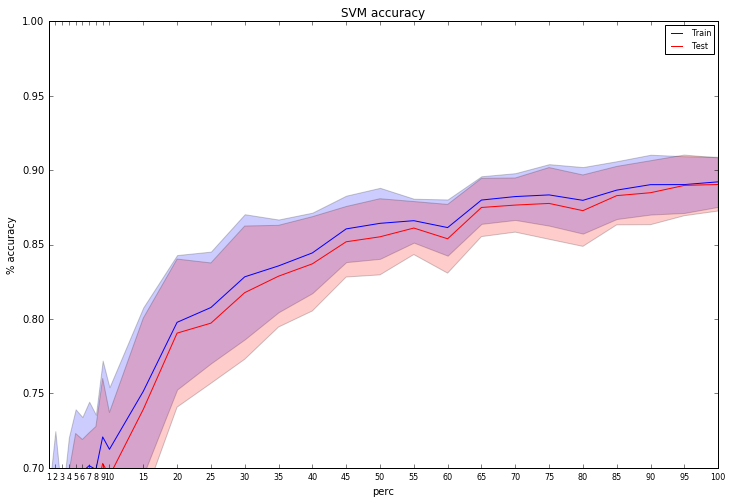

In [10]:
gen_plot( "SVM", svm_acc_train, svm_acc_test, y_lim_min = 0.7 )
plt.show()

### MLP

In [11]:
mlp_acc_train, mlp_acc_test = bootstrap( MLPClassifier, data = shuffled_data, sdata = scaled_shuffled_data )

/Users/masaki/software/scikit-learn/sklearn/neural_network/multilayer_perceptron.py:560: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


perc: 1.0 0.898913043478 0.823687556767 0.0263498229501 0.0156646023849
perc: 2.0 0.882427536232 0.833896457766 0.0149486711927 0.0137781647517
perc: 3.0 0.893236714976 0.86459582198 0.0164641480077 0.0110208767761
perc: 4.0 0.905267938238 0.874386920981 0.0118287378798 0.0119359319764
perc: 5.0 0.920479302832 0.895495004541 0.0101371591496 0.0102944720175
perc: 6.0 0.929582577132 0.907120799273 0.0101633393829 0.0111476522155
perc: 7.0 0.934473820632 0.912661217075 0.0112128612418 0.0094284054059
perc: 8.0 0.946503178928 0.927683923706 0.00747817282924 0.0093833775505
perc: 9.0 0.940637610977 0.923505903724 0.00860321673588 0.00988514733503
perc: 10.0 0.957988380537 0.940672116258 0.00706345798833 0.00868605512674
perc: 15.0 0.966812015504 0.95378746594 0.00405213743219 0.00632309166615
perc: 20.0 0.966448683015 0.958655767484 0.00582483447349 0.0054799035866
perc: 25.0 0.970795173717 0.963578564941 0.00485825036325 0.00486630159416
perc: 30.0 0.971644864341 0.963124432334 0.003488477

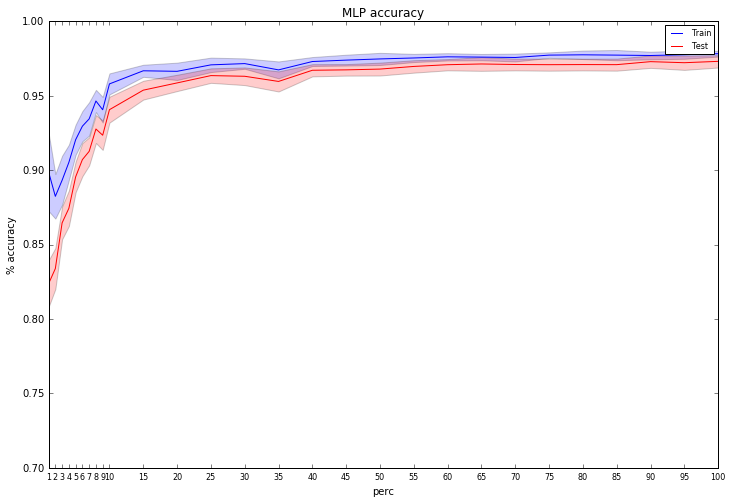

In [12]:
gen_plot( "MLP", mlp_acc_train, mlp_acc_test, y_lim_min = 0.7 )
plt.show()

### Logistic Regression

In [13]:
lr_acc_train, lr_acc_test = bootstrap( LogisticRegression, data = shuffled_data, sdata = scaled_shuffled_data )

perc: 1.0 0.867753623188 0.834986376022 0.0241560989866 0.0184372379708
perc: 2.0 0.875543478261 0.859327883742 0.0223796050764 0.0153943210456
perc: 3.0 0.889734299517 0.871207992734 0.0122577104079 0.0106067334511
perc: 4.0 0.895004541326 0.882870118074 0.0126389273655 0.011875386185
perc: 5.0 0.903050108932 0.890717529519 0.00970660976468 0.0109560129038
perc: 6.0 0.907441016334 0.900181653043 0.0122016234584 0.0112249969271
perc: 7.0 0.911404872991 0.910009082652 0.00909927045125 0.0116912327286
perc: 8.0 0.916439600363 0.909264305177 0.00789981911501 0.0106322908525
perc: 9.0 0.918523002421 0.916548592189 0.0077023335675 0.00934699786609
perc: 10.0 0.924074074074 0.919146230699 0.00658508520173 0.00899703516095
perc: 15.0 0.93226744186 0.927520435967 0.00582423993127 0.00825992185212
perc: 20.0 0.940817438692 0.937039055404 0.00606938672145 0.00737439762434
perc: 25.0 0.943509230993 0.939255222525 0.00392778781731 0.00491820371447
perc: 30.0 0.945591085271 0.944741144414 0.0042623

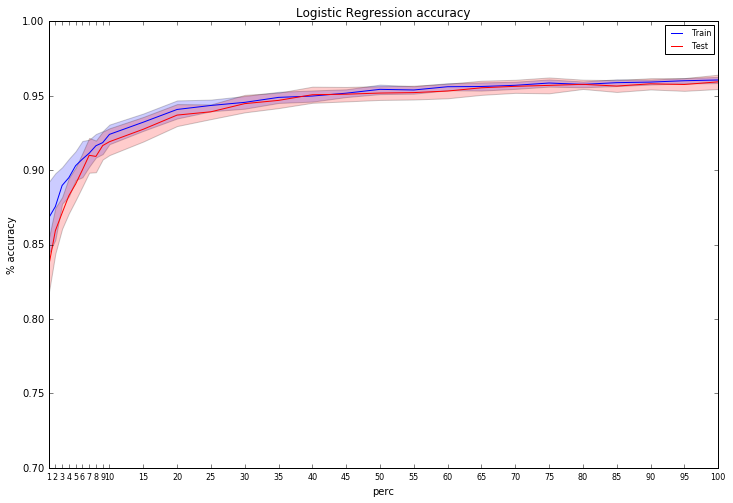

In [14]:
gen_plot( "Logistic Regression", lr_acc_train, lr_acc_test, y_lim_min = 0.7 )
plt.show()

### Random Forest

In [15]:
rf_acc_train, rf_acc_test = bootstrap( RandomForestClassifier, data = shuffled_data, sdata = scaled_shuffled_data )

perc: 1.0 0.985869565217 0.72944595822 0.0101772260183 0.0218689743486
perc: 2.0 0.990036231884 0.789082652134 0.00854527276454 0.0151412905344
perc: 3.0 0.991183574879 0.81229791099 0.00581844901954 0.0136759649977
perc: 4.0 0.990644868302 0.829173478656 0.00490883528315 0.0118968736826
perc: 5.0 0.993391430646 0.839673024523 0.00407523248993 0.011490240616
perc: 6.0 0.991954022989 0.847084468665 0.00232811632243 0.0126852626189
perc: 7.0 0.993934681182 0.858183469573 0.00290537195836 0.00850518479165
perc: 8.0 0.993369663942 0.861634877384 0.00243035207271 0.0116076294278
perc: 9.0 0.993099273608 0.863923705722 0.00325078004409 0.00784204832378
perc: 10.0 0.993318809005 0.868319709355 0.00287841992485 0.0094729754061
perc: 15.0 0.994912790698 0.8851044505 0.00155869263005 0.0103838987089
perc: 20.0 0.995821980018 0.892606721163 0.00156263855895 0.00780254270066
perc: 25.0 0.995973251926 0.895858310627 0.00135443936867 0.00778783266972
perc: 30.0 0.995869670543 0.90123524069 0.0014488

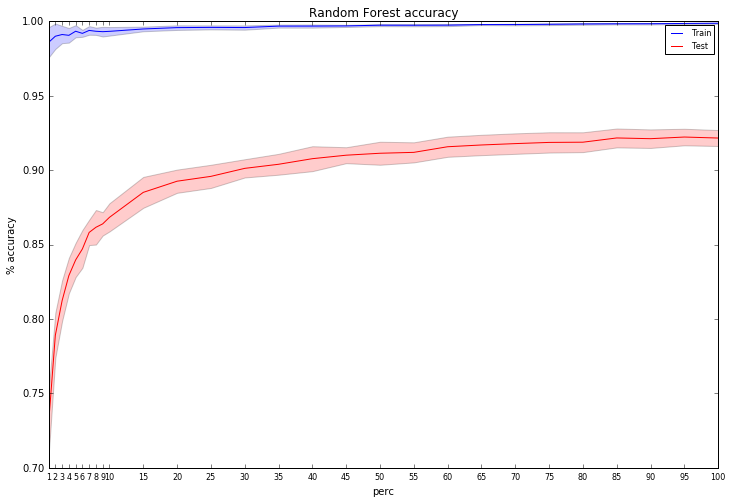

In [16]:
gen_plot( "Random Forest", rf_acc_train, rf_acc_test, y_lim_min = 0.7 )
plt.show()

### Naive Bayes

In [17]:
# naive bayes can't handle values that are <0, don't use scaled values 'sdata', use 'data'
nb_acc_train, nb_acc_test = bootstrap( MultinomialNB, data = shuffled_data, sdata = scaled_shuffled_data )

perc: 1.0 0.71884057971 0.709409627611 0.0476059933497 0.0123339740654
perc: 2.0 0.695108695652 0.707901907357 0.0358956317233 0.0120484042336
perc: 3.0 0.712198067633 0.710735694823 0.02977022518 0.0112868389894
perc: 4.0 0.712261580381 0.708737511353 0.0248798362919 0.00890107323553
perc: 5.0 0.708061002179 0.712352406903 0.0170436664188 0.0104229122112
perc: 6.0 0.704295220811 0.708973660309 0.0154704426081 0.0100775535228
perc: 7.0 0.706946604458 0.708065395095 0.0185702025211 0.00940234815335
perc: 8.0 0.703905540418 0.709972752044 0.0159438708231 0.0092272593714
perc: 9.0 0.704882970137 0.709791099001 0.017534801064 0.011092502903
perc: 10.0 0.714887436456 0.710517711172 0.0139215894631 0.00996386395868
perc: 15.0 0.708236434109 0.708319709355 0.0150346883724 0.00925862232428
perc: 20.0 0.7119164396 0.708574023615 0.0124002519465 0.0077933389535
perc: 25.0 0.711033580462 0.711298819255 0.00959349266708 0.010528372786
perc: 30.0 0.707533914729 0.706721162579 0.00884756120323 0.010

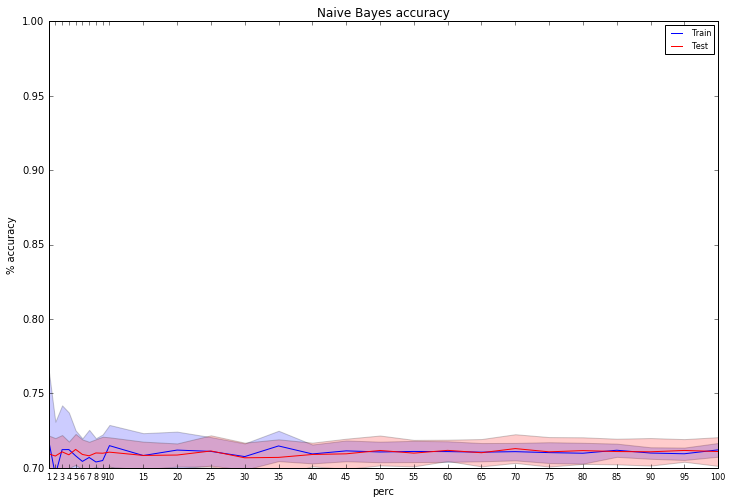

In [18]:
gen_plot( "Naive Bayes", nb_acc_train, nb_acc_test, y_lim_min = 0.7 )
plt.show()

### Meta

In [19]:
meta_acc_train, meta_acc_test = bootstrap( Metaclassifier, model_params = { "model_names" : [ "svm", "neural_network", "naive_bayes", "logistic_regression" ] }, data = shuffled_data, sdata = scaled_shuffled_data )

perc: 1.0 0.864492753623 0.837220708447 0.0367784856245 0.0244273636007
perc: 2.0 0.874094202899 0.858528610354 0.0192447247523 0.0162629293307
perc: 3.0 0.892874396135 0.87229791099 0.0136109557236 0.015543175265
perc: 4.0 0.894368755677 0.886303360581 0.0119949480691 0.0110636844082
perc: 5.0 0.90232389252 0.890844686649 0.0115294717794 0.0139294722787
perc: 6.0 0.90834845735 0.897002724796 0.00991563584729 0.0136290635377
perc: 7.0 0.91021254536 0.903887375114 0.0101262627596 0.0112288766259
perc: 8.0 0.919028156222 0.908973660309 0.00744292724548 0.0117543555883
perc: 9.0 0.9200968523 0.91280653951 0.00884136493148 0.0107445893711
perc: 10.0 0.922839506173 0.919927338783 0.00728074963822 0.00833500491814
perc: 15.0 0.934859496124 0.929609445958 0.00554261236578 0.00662386306404
perc: 20.0 0.939346049046 0.936603088102 0.00482147693035 0.00675593040048
perc: 25.0 0.942229975287 0.940236148955 0.00427110716771 0.00715860508456
perc: 30.0 0.945215600775 0.945304268847 0.00329940170772

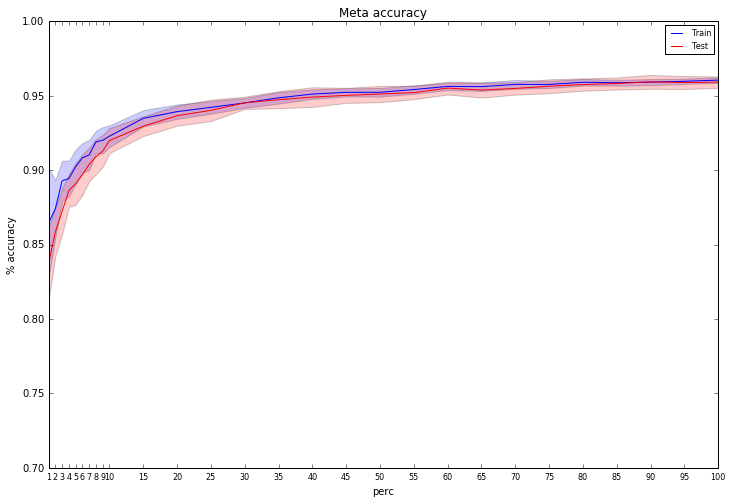

In [20]:
gen_plot( "Meta", meta_acc_train, meta_acc_test, y_lim_min = 0.7 )
plt.show()

## Model Testing: Feature Bootstrap Analysis

aliscore


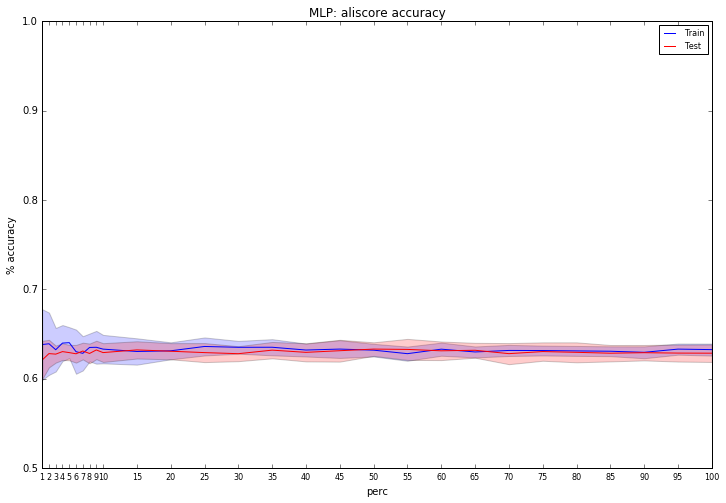

length


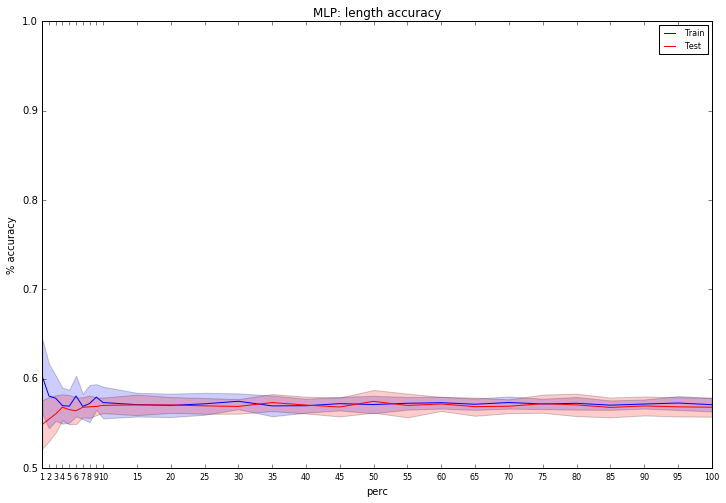

num_seqs


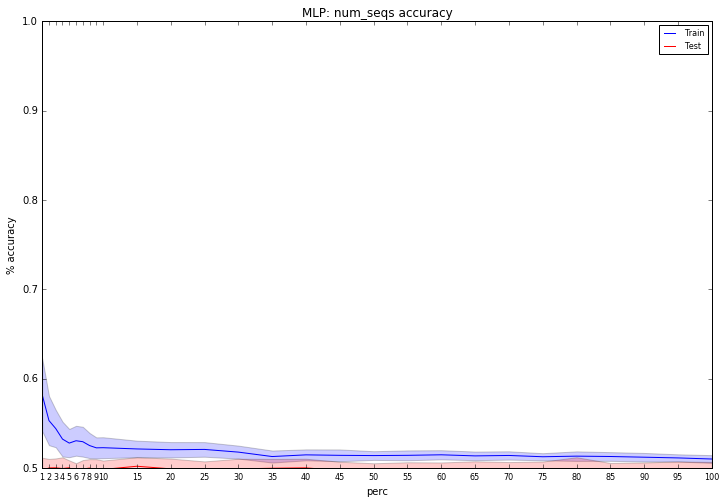

num_gaps


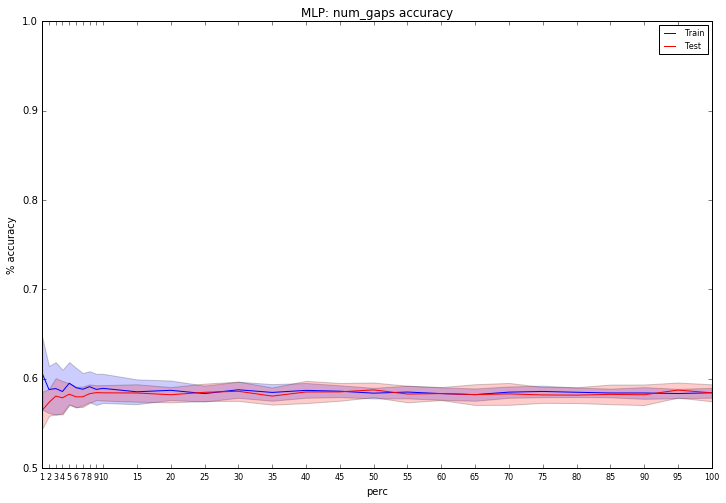

num_amino_acids


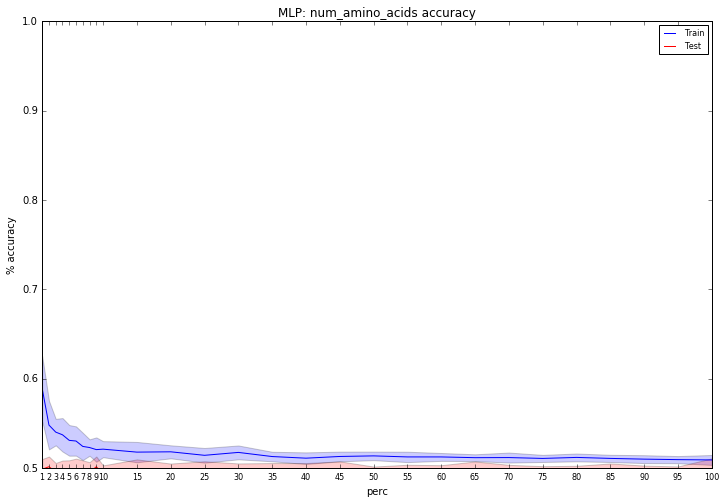

range


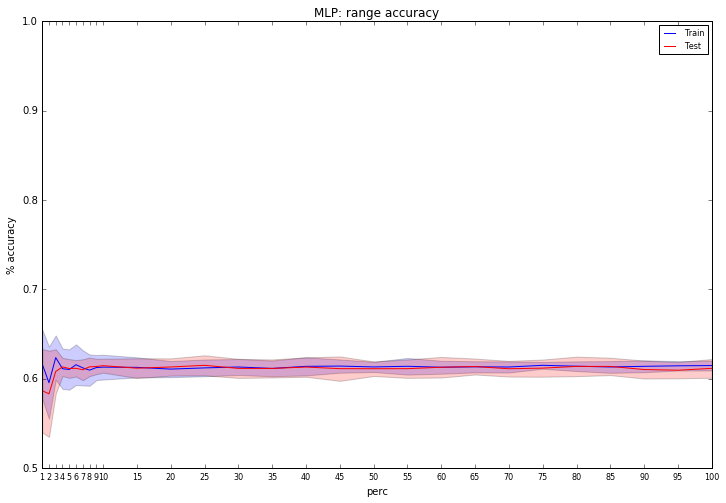

amino_acid_charged


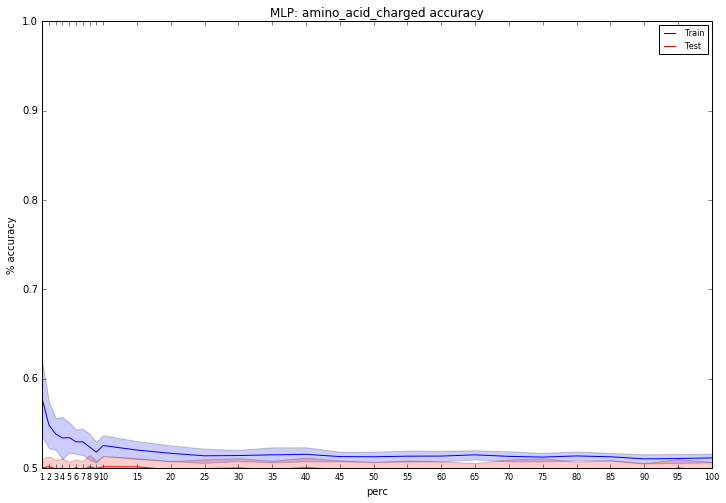

amino_acid_uncharged


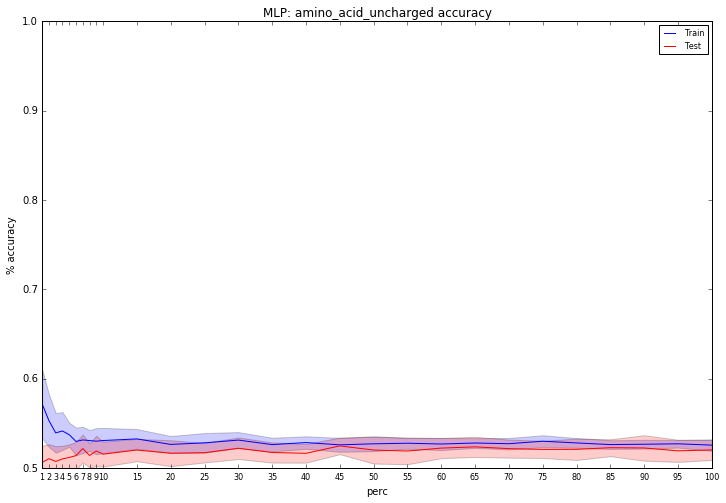

amino_acid_special


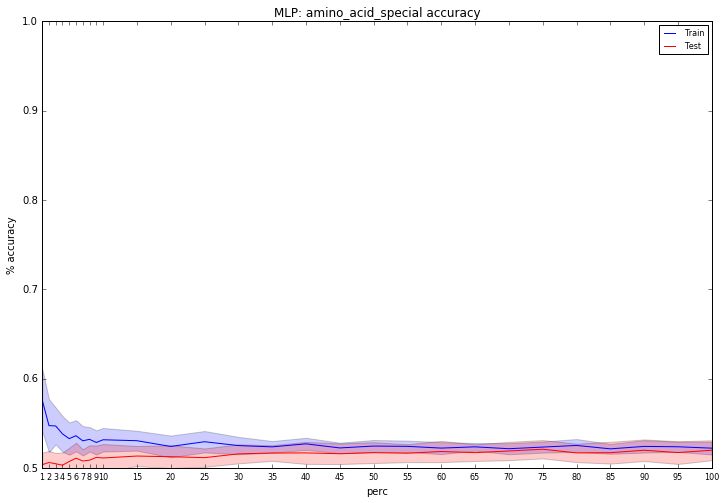

amino_acid_hydrophobic


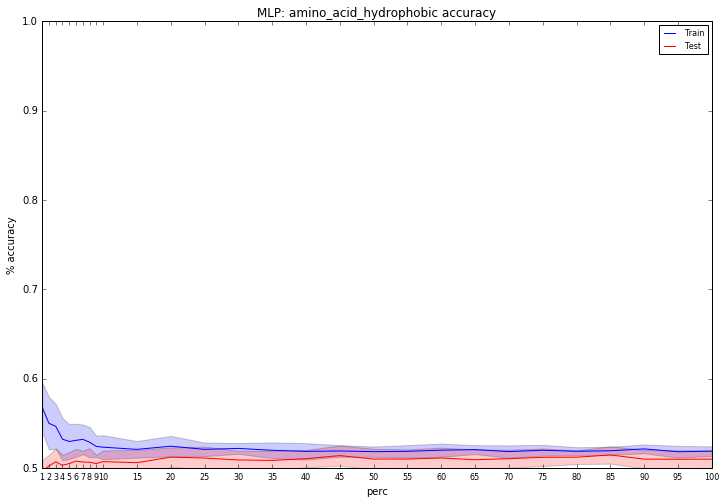

In [21]:
for feature in available_features:
    print feature
    feat_acc_train, feat_acc_test = bootstrap( MLPClassifier, data = shuffled_data, sdata = scaled_shuffled_data, features = [ feature ], verbosity = 0 )
    gen_plot( "MLP: " + feature, feat_acc_train, feat_acc_test, y_lim_min = 0.5 )
    plt.show()